## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/data/eolson/MEOPAR/SS36runs/linkHC201812/'
start_date = datetime.datetime(2017,1,1)
end_date = datetime.datetime(2017,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO()
df1.head()
df2=df1.loc[(df1.Lat>48.9)&(df1.Lat<49.5)&(df1.Lon>-124)]

In [3]:
data=et.matchData(df2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

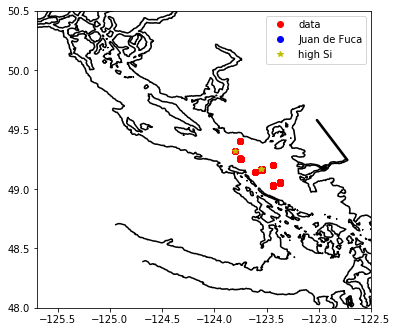

In [4]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

# Nitrate

In [5]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 65
  bias: -4.68327697985562
  RMSE: 7.539157346167396
  WSS: 0.8104171802188898
15 m<=z<22 m:
  N: 24
  bias: -2.514627240498857
  RMSE: 3.8698009977083645
  WSS: 0.8761683780550746
z>=22 m:
  N: 185
  bias: -0.5142221869391328
  RMSE: 2.150874039991214
  WSS: 0.832895723576462
all:
  N: 274
  bias: -1.6784494965194483
  RMSE: 4.233079089902489
  WSS: 0.9333590684275997


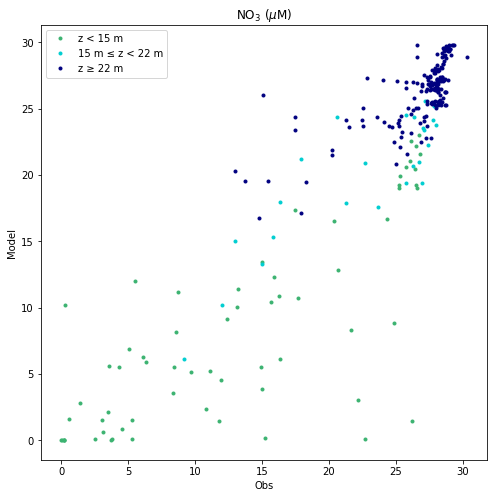

In [6]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

Nitrate, z<15
Feb-Mar:
  N: 12
  bias: -5.447955614725746
  RMSE: 5.574334035454976
  WSS: 0.17071541231177734
April:
  N: 11
  bias: -1.845631287314676
  RMSE: 4.910060276034646
  WSS: 0.6338397343283194
May-Jun:
  N: 19
  bias: -1.9558931085035987
  RMSE: 3.1803128618664136
  WSS: 0.8459058063321117
Sep-Oct:
  N: 23
  bias: -7.894505351820716
  RMSE: 11.159477661254003
  WSS: 0.5147064419877116


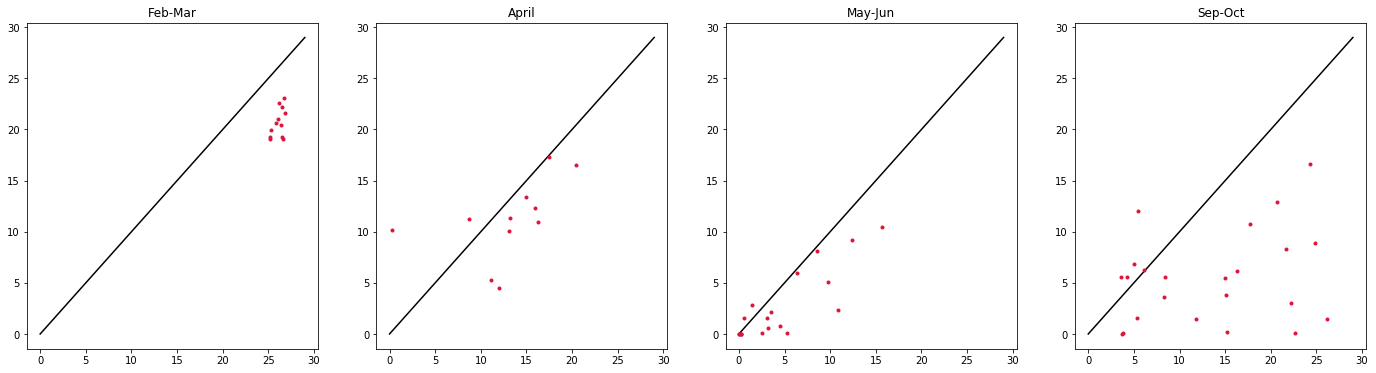

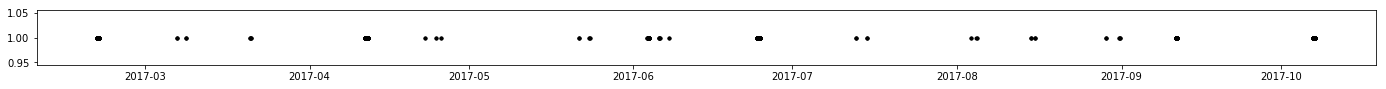

In [7]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,9,1))&(data.dtUTC>dt.datetime(2017,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,12,1))&(data.dtUTC>dt.datetime(2017,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

#ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,4,1))&(data.dtUTC>dt.datetime(2016,2,1))
#ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
#ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,5,1))&(data.dtUTC>dt.datetime(2016,4,1))
#ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

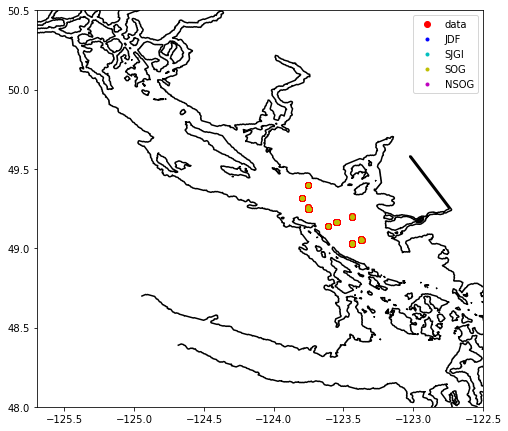

In [8]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

(0, 35)

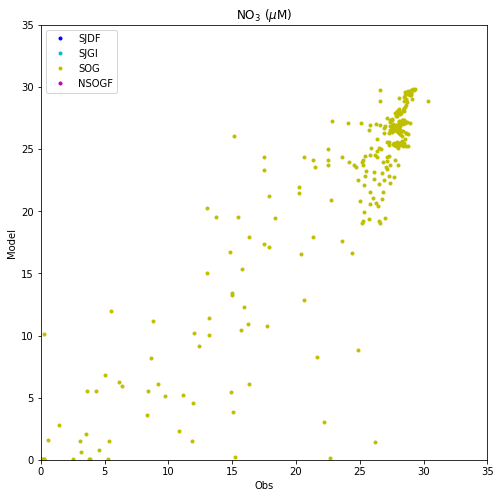

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.set_xlim(0,35)
ax.set_ylim(0,35)

(-40, 20)

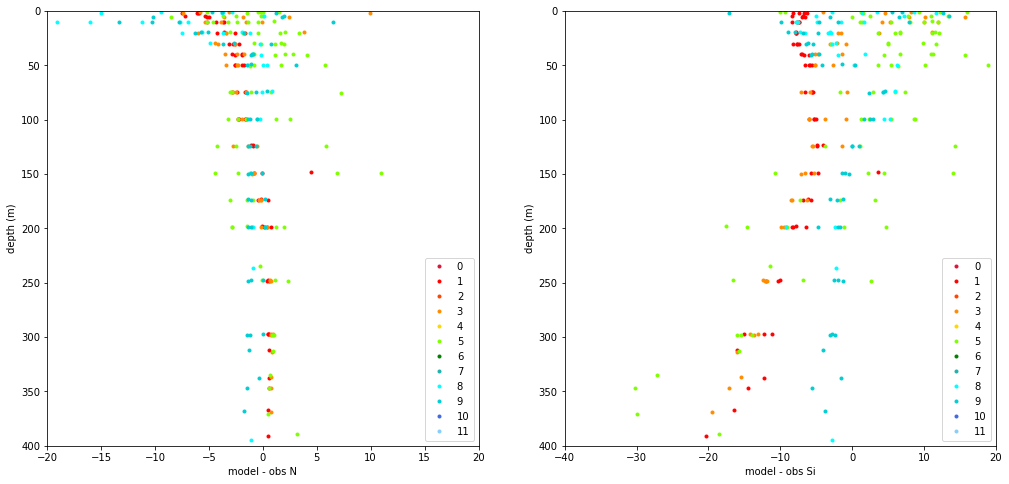

In [10]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[0].set_xlim(-20,20)
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

# Silicate

In [11]:
print('Nitrate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

Nitrate
z<15 m:
  N: 65
  bias: 2.1192044184758103
  RMSE: 8.910322699445816
  WSS: 0.8562462836959122
15 m<=z<22 m:
  N: 24
  bias: -0.5942577934265145
  RMSE: 7.26141469731623
  WSS: 0.8359029170976934
z>=22 m:
  N: 185
  bias: -3.8227036066828504
  RMSE: 9.126507321920545
  WSS: 0.5222893380845844
all:
  N: 274
  bias: -2.130343310502319
  RMSE: 8.926975822974534
  WSS: 0.7952216199623036
obs Si < 50:
  N: 108
  bias: 5.9863431888156455
  RMSE: 8.568136697419815
  WSS: 0.8046074579811164


(0, 80)

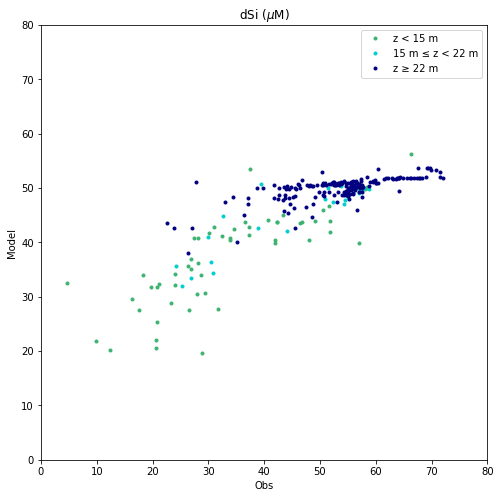

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')
ax.set_xlim(0,80)
ax.set_ylim(0,80)

Silicate, z<15
Feb-Mar:
  N: 12
  bias: -7.377624460856119
  RMSE: 7.409536745704207
  WSS: 0.1074813487550732
April:
  N: 11
  bias: 9.238477908047766
  RMSE: 11.990428294772832
  WSS: 0.5100912539470712
May-Jun:
  N: 19
  bias: 5.489399903949938
  RMSE: 8.913796218610065
  WSS: 0.8445402295668533
Sep-Oct:
  N: 23
  bias: 0.8851271985924711
  RMSE: 7.831519084641401
  WSS: 0.3662826423694152


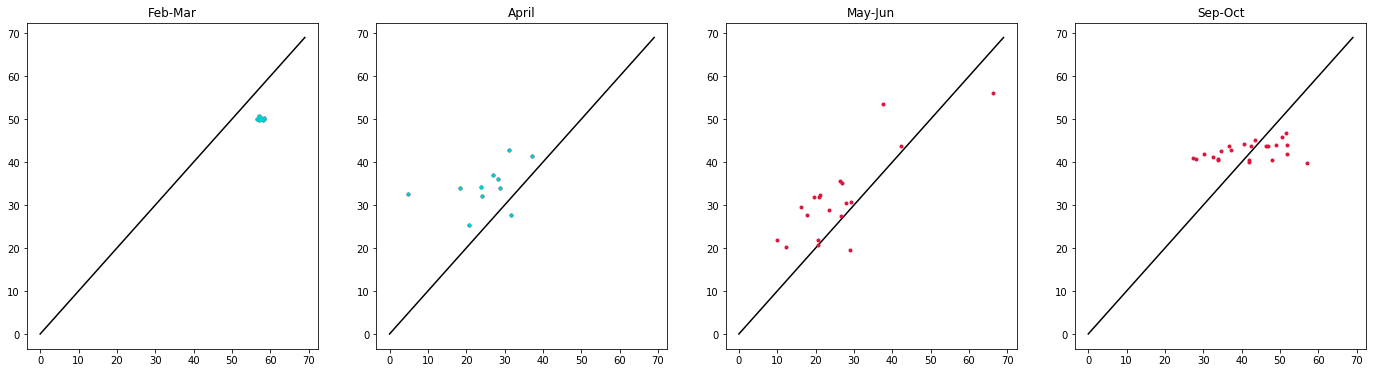

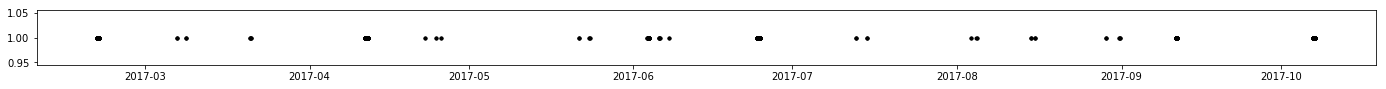

In [13]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,9,1))&(data.dtUTC>dt.datetime(2017,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,12,1))&(data.dtUTC>dt.datetime(2017,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,4,1))&(data.dtUTC>dt.datetime(2017,2,1))
ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2017,5,1))&(data.dtUTC>dt.datetime(2017,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))


print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2017,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

(0, 80)

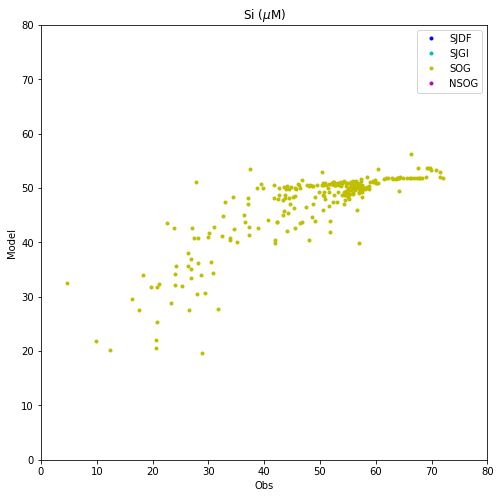

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOG')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.set_xlim(0,80)
ax.set_ylim(0,80)

# Ratios

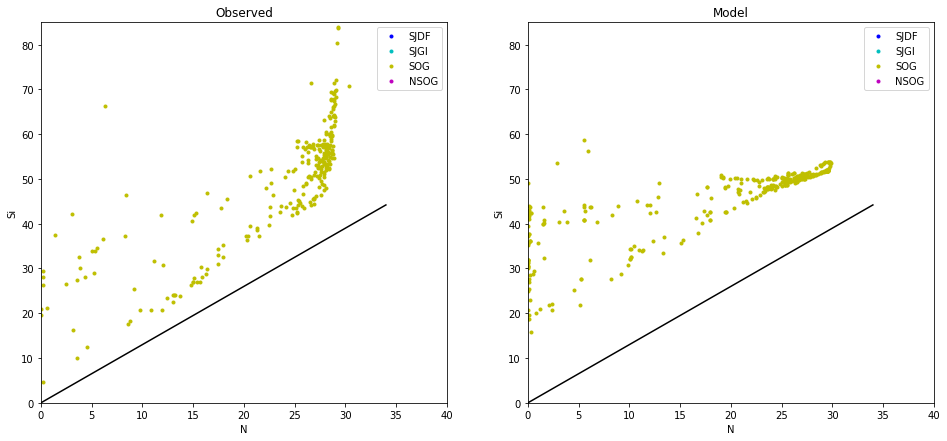

In [15]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

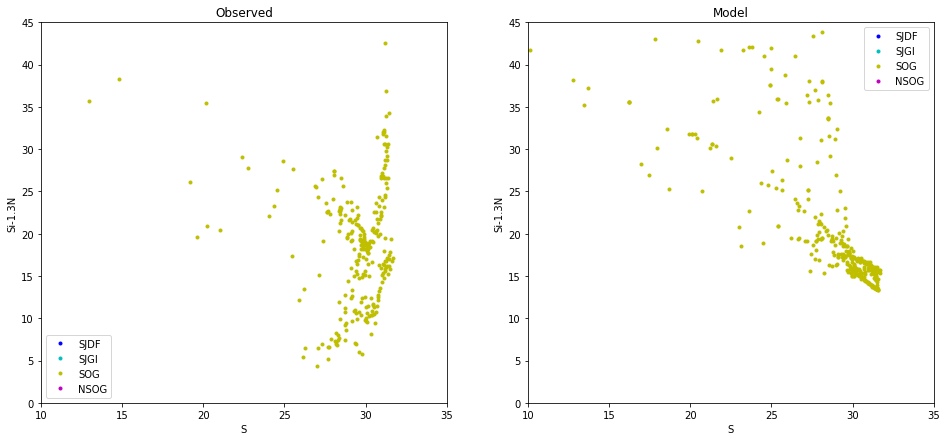

In [16]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

In [17]:
data.loc[data.Si>65,['Month','Lat','Lon','Z','Si']]

,Month,Lat,Lon,Z,Si
14,2.0,49.027667,-123.437833,297.5,66.85
15,2.0,49.027667,-123.437833,311.8,67.82
31,2.0,49.163167,-123.551000,347.1,66.29
32,2.0,49.163167,-123.551000,367.2,68.34
43,2.0,49.250833,-123.749000,390.9,72.03
88,4.0,49.030000,-123.437000,314.0,67.87
107,4.0,49.164167,-123.549833,298.0,65.52
108,4.0,49.164167,-123.549833,347.1,69.04
109,4.0,49.164167,-123.549833,368.5,71.44
129,4.0,49.318333,-123.799000,297.5,66.13


# Chlorophyll

In [18]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [19]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 94
  bias: 0.16864379717025918
  RMSE: 0.48210312078615297
  WSS: 0.5364442460261537
z>=15 m:
  N: 25
  bias: 0.5106228890237612
  RMSE: 0.6642478406495784
  WSS: 0.503118381656172
all:
  N: 119
  bias: 0.2404881441983059
  RMSE: 0.5256323221929067
  WSS: 0.6347610747044823


Chl
z<15 m:
  N: 94
  bias: -0.7018025440326392
  RMSE: 5.828554966206629
  WSS: 0.49282473165919505
z>=15 m:
  N: 25
  bias: 0.975244804380834
  RMSE: 1.868217341990596
  WSS: 0.3194650458379691
all:
  N: 119
  bias: -0.3494816725172032
  RMSE: 5.250553298068821
  WSS: 0.5475223975788108


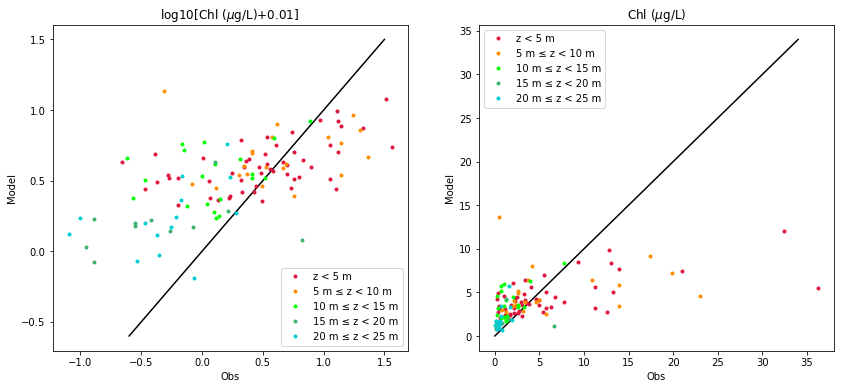

In [20]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')